## 算法原理

令人遗憾的是所有有效的算法都启发式算法-不能保证质量或者说不能评定求解质量，尚未发现系统、综合评价k-medoids算法的文献，各个算法处于自说自话孤立的状态。

比较Exhaust(穷举)法、Exchange法、Build-Swap法(自我实现)、fastkmedoids包、ClusterR包、cluster包的k-medoids算法性能


- Exhaust法是将枚举尝试所有可能的簇心组合，所以能找到全局最优解
  
- Lloyd_Similar法：
  1. 任意选取k个初始中心点medoids；
  2. 按照与medoids最近的原则，将剩余点分配到当前最佳的medoids代表的类中;
  3. 在每一类中，计算每个样本点与其他点的距离之和，选取距离之和最小的点作为新的medoids;
  4. 重复2-3的过程，直到所有的medoids点不再发生变化，或已达到设定的最大迭代次数;
- Exchange法
  1. Select K points as the initial representative objects.
  2. Assign each point to the cluster with the nearest representative object.
  3. Randomly select a nonrepresentative object x.
  4.  Compute the total td S of swapping the representative object m with x.
  5.  If S < 0, then swap m with x to form the new set of K representative objects.
  6. to 3 until Convergence criterion is met.

### Exhaust法
--遍历尝试所有可能的簇心组合，所以能找到全局最优解

In [3]:
exhaust <- function(dm, k) {
  n <- nrow(dm)
  ss <- combn(n, k) # 可能的medoids组合
  m <- ncol(ss) # 可能的medoids组合个数

  td_R <- rep(Inf, m)   #用于记录td
  
  library(purrr)
  pb <- txtProgressBar(style = 3)
  for (i in (1:m)) {
    s <- ss[, i]
    b <- apply((dm[, s]), 1, which.min) # 找到归属
    td_R[i] <- sum((1:k) %>% map_dbl(function(x) sum(dm[b == x, s[x]])))
    setTxtProgressBar(pb, i / m)
  }
  id <- which.min(td_R)
  return(list(medoids = ss[, id], td = td_R[id]))
}

### Lloyd_Similar法

  1. 任意选取k个初始中心点medoids；
  2. 按照与medoids最近的原则，将剩余点分配到当前最佳的medoids代表的类中;
  3. 在每一类中，计算每个样本点与其他点的距离之和，选取距离之和最小的点作为新的medoids;
  4. 重复2-3的过程，直到所有的medoids点不再发生变化，或已达到设定的最大迭代次数;

In [28]:
#-------------------Lloyd_Similar法------------------------
LS <- function(dm, k = 2, tol = 0.01, seed = 1) {
  # dm--距离矩阵
  # k--聚类个数
  # tol--用于判断收敛的容忍度
  # seed-用于随机生成初始簇心集的随机数

  n <- nrow(dm) # 数据量
  # 行列命名，便于标识各簇成员、簇心
  rownames(dm) <- 1:n
  colnames(dm) <- 1:n

  # ---------medoids随机初始化-------
  set.seed(seed)
  s_m <- sample(n, k) # 簇心集合

  B <- matrix(nc = n, nr = k) # 各簇的元素
  td_R <- NULL # 记录td的变化过程

  repeat{
    #-------固定簇心，调整归属----------------
    B <- (dm[, s_m] == apply(dm[, s_m], 1, min))

    #-如果某簇只有原簇心，没有别的归属，则返回非正常置，重新初始化簇心-
    if (any(colSums(B) == 1)) {
      return(FALSE)
    }

    td <- 0
    for (i in 1:k) {
      td <- td + sum(dm[B[, i], as.numeric(colnames(B)[i])])
    }
    td_R <- c(td, td_R)

    #-------固定归属，调整簇心----------------
    s_m <- NULL
    td <- 0
    for (i in 1:k) {
      s_m <- c(s_m, as.numeric(names(which.min(rowSums(dm[B[, i], B[, i]])))))
      colnames(B)[i] <- s_m[i] # 调整簇心
      td <- td + sum(dm[B[, i], as.numeric(colnames(B)[i])])
    }
    td_R <- c(td, td_R)

    if (td_R[2] - td_R[1] < tol) break
  }
  return(list(medoids = sort(s_m), td = td))
}

### Exchange法

--Hennig, C., et al. Handbook of Cluster Analysis. 2015。时间复杂度为*O*(tk(n-k))，其中n为样例数，k为聚类数，t为收敛的循环数，麻烦的是t未知，可能随着n、r而变。

1. Initialize: randomly select (without replacement) K of the N data points as the
initial medoids (as Steinley, notes in the context of K -means clustering, this type of
initialization strategy can be problematic (Steinley, 2003)).
2. Assign each observation to the medoid with which it is closest, where closest is
based on a speciﬁc distance measure (the most common distance to minimize
is the Euclidean distance) and compute the total cost across all observations,
where the cost is the sum of the distance of each observation to its associated
medoid.
3. For each medoid k,for k = 1, .. . , K consider all N - K nonmedoid, o.Swap k and
o and recompute the total cost.
4. Select the solution with the lowest cost.
5. Repeat steps 2–4 until the set of medoids does not change.

In [6]:
exchange <- function(dm, k, seed = 10) {
  # --簇心集初始化--
  set.seed(seed)
  n <- nrow(dm)
  s_m <- sample(n, k)

  s_mR <- matrix(nc = k, nr = 0) # 用于记录簇心的变迁-Record
  td_min <- Inf # 记录最小的td（total deviation）

  library(purrr)
  repeat {
    t <- 0 # 多少次尝试替换，td没有降低

    i_break <- FALSE # i循环是否中断
    for (i in 1:k) {
      for (j in (1:n)[-s_m]) {
        s <- s_m # s-准备被替换的簇心集
        s[i] <- j # 用j点替换簇心集中的第i点

        # --------------------计算簇心集s的td-------------------------
        b <- apply(dm[, s], 1, which.min)
        td <- sum((1:k) %>% map_dbl(function(x) sum(dm[b == x, s[x]])))

        if (td < td_min) {
          s_m <- s
          td_min <- td
          t <- 0 # 重新置为0
        } else {
          t <- t + 1
        }
      }
    }

    if (t >= ((n - k) * k)) {
      break # 簇心集不发生一次替换
    }
  }

  return(list(medoids = sort(s_m), td = td_min))
}

In [8]:
# ----------------------数据生成------------------------------
n <- 100 # 数据量
set.seed(3)
x <- rbind(
  matrix(rnorm(n, sd = 0.25), ncol = 2),
  matrix(rnorm(n, mean = 1, sd = 0.25), ncol = 2)
)

# 距离方阵
dm <- ClusterR::distance_matrix(x, upper = TRUE, diagonal = TRUE)

# The distance matrix (lower triangular matrix, column wise storage)
dv <- as.vector(dist(x))    #用于fastkmedoids包

## k=2

可见此时ClusterR包算法未能找到最优解

### Exhaust法

In [50]:
k <- 2 # 聚类的个数
sl <- exhaust(dm, k)

cat("\n")
cat("Exhaust Algorithm solutuion")
cat("\n")
cat("medoid_indices:", sl$medoids)
cat("\n")
cat("best_td:", sl$td)

Warning message:
"package 'purrr' was built under R version 4.3.3"


  |======================================================================| 100%
Exhaustive Algorithm solutuion
medoid_indices: 20 57
best_cost: 31.86491

### Lloyd_Similar法
--时间复杂度为*O*(tk(n-k))，其中n为样例数，k为聚类数，t为收敛的循环数，麻烦的是t未知，可能随着n、r而变。

In [29]:
k <- 2 # 聚类个数
t <- 100 # 试验次数

rc <- matrix(nc = k + 1, nr = t) # 用于记录簇心及簇心距离总和
colnames(rc)=c(paste0("medoid",1:k),"td")
pb <- txtProgressBar(style = 3)
for (seed in 1:t) {
  rs <- LS(dm, k, seed)
  rc[seed, 1:k] <- sort(rs$medoids)
  rc[seed, k + 1] <- sort(rs$td)
  setTxtProgressBar(pb, seed / t)
}

cat("\n")
cat("best solutions:")
cat("\n")
print(rc[rc[, k + 1] == min(rc[, k + 1]), ])   #最优解

bc <- table(rc[, k + 1])[1]
cat("\n")
cat(paste0("hit probability: ", bc / t))     #最优解命中率

  |======================================================================| 100%
best solutions:
       medoid1 medoid2     cost
  [1,]      20      57 31.86491
  [2,]      20      57 31.86491
  [3,]      20      57 31.86491
  [4,]      20      57 31.86491
  [5,]      20      57 31.86491
  [6,]      20      57 31.86491
  [7,]      20      57 31.86491
  [8,]      20      57 31.86491
  [9,]      20      57 31.86491
 [10,]      20      57 31.86491
 [11,]      20      57 31.86491
 [12,]      20      57 31.86491
 [13,]      20      57 31.86491
 [14,]      20      57 31.86491
 [15,]      20      57 31.86491
 [16,]      20      57 31.86491
 [17,]      20      57 31.86491
 [18,]      20      57 31.86491
 [19,]      20      57 31.86491
 [20,]      20      57 31.86491
 [21,]      20      57 31.86491
 [22,]      20      57 31.86491
 [23,]      20      57 31.86491
 [24,]      20      57 31.86491
 [25,]      20      57 31.86491
 [26,]      20      57 31.86491
 [27,]      20      57 31.86491
 [28,]  

### Exchange法

  |======================================================================| 100%

best medoids: (20, 57)
best td: 31.8649135490429
hit probability: 1

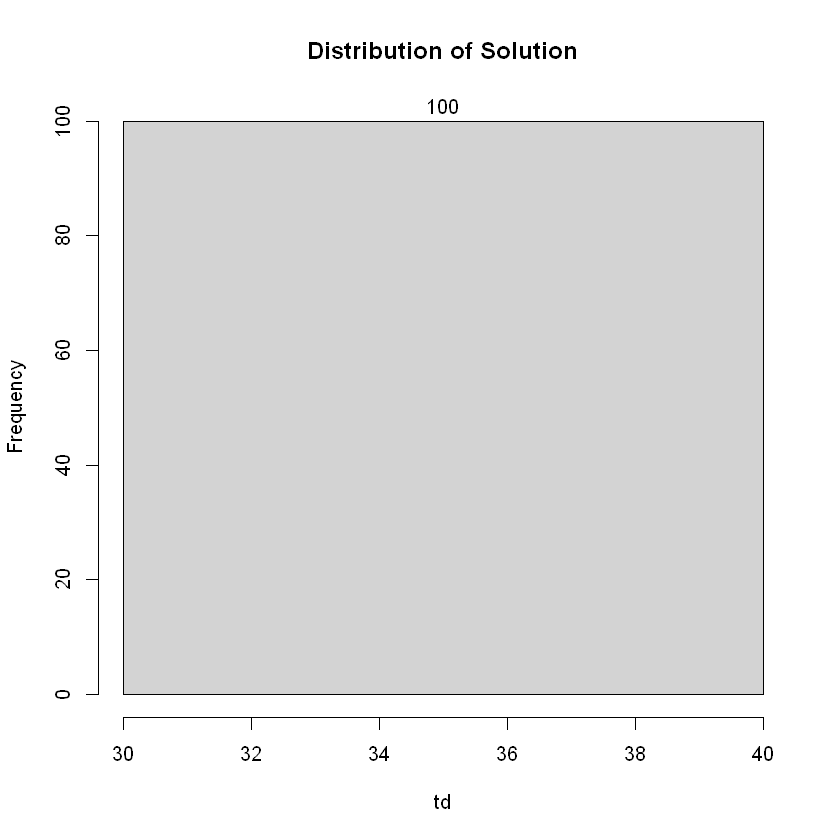

In [22]:
k <- 2 # 聚类个数
T <- 100 # 试验次数
rc <- matrix(nr = T, nc = k + 1)

pb <- txtProgressBar(style = 3)
for (seed in 1:T) {
  sl <- exchange(dm, k, seed) # sl-solution

  rc[seed, 1] <- sl$td
  rc[seed, 2:(k + 1)] <- sl$medoids
  setTxtProgressBar(pb, seed / T)
}

id <- which.min(rc[, 1])
cat("\n")
bc <- table(rc[, 1])[1]
cat("\n")
cat(paste0("best medoids: (", toString(rc[id, 2:(k + 1)]), ")"))
cat("\n")
cat(paste0("best td: ", names(bc)))
cat("\n")
cat(paste0("hit probability: ", bc / T))     #最优解命中率
hist(rc[, 1] ,100, labels = TRUE,xlab = "td", main = "Distribution of Solution")

### Build-Swap法

In [ ]:
m <- 2  #聚类的个数
sseR <- NULL

# build phase
s <- which.min(rowSums(dm))
while (length(s) < m) {
  ri <- matrix(nc = 2, nr = 0) # 用于记录点i的情况
  for (i in (1:n)[-s]) {
    gi <- 0
    for (j in (1:n)[-c(s, i)]) {
      gi <- gi + max(min(dm[j, s]) - dm[j, i], 0)
    }
    ri <- rbind(ri, matrix(c(i, gi), nc = 2, byrow = TRUE))
  }
  s <- c(s, ri[which.max(ri[, 2]), 1])
}
sse <- 0
# 计算簇心集s的sse
for (u in 1:m) {
  h <- s[-u]
  b <- TRUE # 到u类最近的点
  for (v in h) {
    b <- (b & (dm[, s[u]] < dm[, v]))
  }
  sse <- sse + sum(dm[b, s[u]])
}
sseR <- c(sseR, sse)

# swap phase
repeat{
  T <- matrix(0, nc = n, nr = n)
  for (i in s) {
    for (h in (1:n)[-s]) {
      for (j in (1:n)[-c(s, h)]) {
        if (dm[j, i] > min(dm[j, s])) {
          if (dm[j, h] < min(dm[j, s])) {
            k <- dm[j, h] - min(dm[j, s])
          } else {
            k <- 0
          }
        } else {
          if (dm[j, h] < min(dm[j, s[-i]])) {
            k <- dm[j, h] - min(dm[j, s])
          } else {
            k <- dm[j, h] - min(dm[j, s[-i]])
          }
        }
        T[i, h] <- T[i, h] + k
      }
    }
  }

  if (min(T) >= 0) {
    break
  } else {
    id <- which(T == min(T), arr.ind = TRUE)
    s[s == id[1]] <- id[2]
    sse <- 0
    # 计算簇心集s的sse
    for (u in 1:m) {
      h <- s[-u]
      b <- TRUE # 到u类最近的点
      for (v in h) {
        b <- (b & (dm[, s[u]] < dm[, v]))
      }
      sse <- sse + sum(dm[b, s[u]])
    }
    sseR <- c(sseR, sse)
  }
}

cat("pamBS Algorithm solutuion")
cat("\n")
cat("medoid_indices:", sort(s))
cat("\n")
cat("best_td:", sse)

pamBS Algorithm solutuion
medoid_indices: 20 57
best_dissimilarity: 31.86491

### ClusterR包

In [ ]:
library(ClusterR)

k <- 2   #聚类的个数
cm <- Cluster_Medoids(x, k, distance_metric = "euclidean")

cat("package ClusterR solutuion")
cat("\n")
cat("medoid_indices:", sort(cm$medoid_indices))
cat("\n")
cat("best_td:", cm$best_td)

Warning message:
"The `seed` argument of `Cluster_Medoids()` is deprecated as of ClusterR 1.2.6.
ℹ The 'seed' parameter will be removed in version 1.4.0"


package ClusterR solutuion
medoid_indices: 25 57
best_dissimilarity: 31.97467

### cluster包

In [ ]:
library(cluster)

k <- 2   #聚类的个数
pm <- pam(x, k, metric = "euclidean")

cat("package cluster solutuion")
cat("\n")
cat("medoid_indices:", sort(pm$id.med))
cat("\n")
cat("best_td:", n * pm$objective[2])

Warning message:
"package 'cluster' was built under R version 4.3.3"


package cluster solutuion
medoid_indices: 20 57
best_dissimilarity: 31.86491

### fastkmedoids包

In [40]:
library(fastkmedoids)
pm <- pam(dv,100,2)

cat("pam(package fastkmedoids) solutuion:")
cat("\n")
cat("medoid_indices:", sort(pm@medoids)+1)
cat("\n")
cat("best_td:", pm@td)

pam(package fastkmedoids) solutuion:


medoid_indices: 20 57
best_cost: 31.86491

In [41]:
library(fastkmedoids)
fp <- fastpam(dv,100,2)

cat("fastpam(package fastkmedoids) solutuion:")
cat("\n")
cat("medoid_indices:", sort(fp@medoids)+1)
cat("\n")
cat("best_td:", fp@td)

fastpam(package fastkmedoids) solutuion:
medoid_indices: 20 57
best_cost: 31.86491

## k=3

可见此时ClusterR包、cluster包算法未能找到最优解

In [ ]:
# 数据生成
n <- 100 # 数据量
set.seed(3)
x <- rbind(
  matrix(rnorm(n, sd = 0.25), ncol = 2),
  matrix(rnorm(n, mean = 1, sd = 0.25), ncol = 2)
)
# 距离方阵
dm <- ClusterR::distance_matrix(x, upper = TRUE, diagonal = TRUE)

### Exhaust法

In [4]:
k <- 3 # 聚类的个数
sl <- exhaust(dm, k)

cat("\n")
cat("Exhaust Algorithm solutuion")
cat("\n")
cat("medoid_indices:", sl$medoids)
cat("\n")
cat("best_td:", sl$td)

Warning message:
"package 'purrr' was built under R version 4.3.3"


  |======================================================================| 100%
Exhaustive Algorithm solutuion
medoid_indices: 20 61 67
best_cost: 27.28273

### Lloyd_Similar法

In [31]:
k <- 3 # 聚类个数
t <- 100 # 试验次数

rc <- matrix(nc = k + 1, nr = t) # 用于记录簇心及簇心距离总和
colnames(rc)=c(paste0("medoid",1:k),"td")
pb <- txtProgressBar(style = 3)
for (seed in 1:t) {
  rs <- LS(dm, k, seed)
  rc[seed, 1:k] <- sort(rs$medoids)
  rc[seed, k + 1] <- sort(rs$td)
  setTxtProgressBar(pb, seed / t)
}

cat("\n")
cat("best solutions:")
cat("\n")
print(rc[rc[, k + 1] == min(rc[, k + 1]), ])   #最优解

bc <- table(rc[, k + 1])[1]
cat("\n")
cat(paste0("hit probability: ", bc / t))     #最优解命中率

  |======================================================================| 100%
best solutions:
      medoid1 medoid2 medoid3     cost
 [1,]       6      26      57 28.15211
 [2,]       6      26      57 28.15211
 [3,]       6      26      57 28.15211
 [4,]       6      26      57 28.15211
 [5,]       6      26      57 28.15211
 [6,]       6      26      57 28.15211
 [7,]       6      26      57 28.15211
 [8,]       6      26      57 28.15211
 [9,]       6      26      57 28.15211

hit probability: 0.09

### Exchange法

  |======================================================================| 100%

best medoids: (20, 61, 67)
best td: 27.2827344194388
hit probability: 0.16

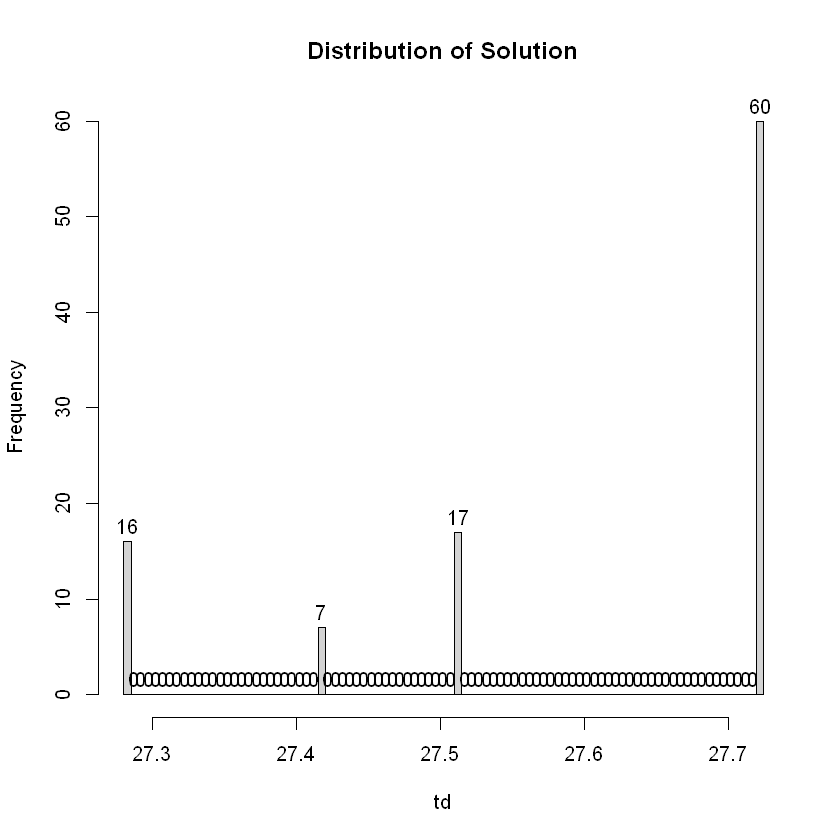

In [19]:
k <- 3 # 聚类个数
T <- 100 # 试验次数
td_r <- vector(length = T) # 用于记录每次试验的结果
rc <- matrix(nr = T, nc = k + 1)

pb <- txtProgressBar(style = 3)
for (seed in 1:T) {
  sl <- exchange(dm, k, seed) # sl-solution

  rc[seed, 1] <- sl$td
  rc[seed, 2:(k + 1)] <- sl$medoids
  setTxtProgressBar(pb, seed / T)
}

id <- which.min(rc[, 1])
cat("\n")
bc <- table(rc[, 1])[1]
cat("\n")
cat(paste0("best medoids: (", toString(rc[id, 2:(k + 1)]), ")"))
cat("\n")
cat(paste0("best td: ", names(bc)))
cat("\n")
cat(paste0("hit probability: ", bc / T))     #最优解命中率
hist(rc[, 1] ,100, labels = TRUE,xlab = "td", main = "Distribution of Solution")

### Build-Swap法

In [ ]:
m <- 3  #聚类的个数
sseR <- NULL

# build phase
s <- which.min(rowSums(dm))
while (length(s) < m) {
  ri <- matrix(nc = 2, nr = 0) # 用于记录点i的情况
  for (i in (1:n)[-s]) {
    gi <- 0
    for (j in (1:n)[-c(s, i)]) {
      gi <- gi + max(min(dm[j, s]) - dm[j, i], 0)
    }
    ri <- rbind(ri, matrix(c(i, gi), nc = 2, byrow = TRUE))
  }
  s <- c(s, ri[which.max(ri[, 2]), 1])
}
sse <- 0
# 计算簇心集s的sse
for (u in 1:m) {
  h <- s[-u]
  b <- TRUE # 到u类最近的点
  for (v in h) {
    b <- (b & (dm[, s[u]] < dm[, v]))
  }
  sse <- sse + sum(dm[b, s[u]])
}
sseR <- c(sseR, sse)

# swap phase
repeat{
  T <- matrix(0, nc = n, nr = n)
  for (i in s) {
    for (h in (1:n)[-s]) {
      for (j in (1:n)[-c(s, h)]) {
        if (dm[j, i] > min(dm[j, s])) {
          if (dm[j, h] < min(dm[j, s])) {
            k <- dm[j, h] - min(dm[j, s])
          } else {
            k <- 0
          }
        } else {
          if (dm[j, h] < min(dm[j, s[-i]])) {
            k <- dm[j, h] - min(dm[j, s])
          } else {
            k <- dm[j, h] - min(dm[j, s[-i]])
          }
        }
        T[i, h] <- T[i, h] + k
      }
    }
  }

  if (min(T) >= 0) {
    break
  } else {
    id <- which(T == min(T), arr.ind = TRUE)
    s[s == id[1]] <- id[2]
    sse <- 0
    # 计算簇心集s的sse
    for (u in 1:m) {
      h <- s[-u]
      b <- TRUE # 到u类最近的点
      for (v in h) {
        b <- (b & (dm[, s[u]] < dm[, v]))
      }
      sse <- sse + sum(dm[b, s[u]])
    }
    sseR <- c(sseR, sse)
  }
}

cat("pamBS Algorithm solutuion")
cat("\n")
cat("medoid_indices:", sort(s))
cat("\n")
cat("best_td:", sse)

pamBS Algorithm solutuion
medoid_indices: 20 61 67
best_dissimilarity: 27.28273

### ClusterR包

  |======================================================================| 100%
Exchange Algorithm solutuion
medoids: 11 45 57
sse: 27.72188

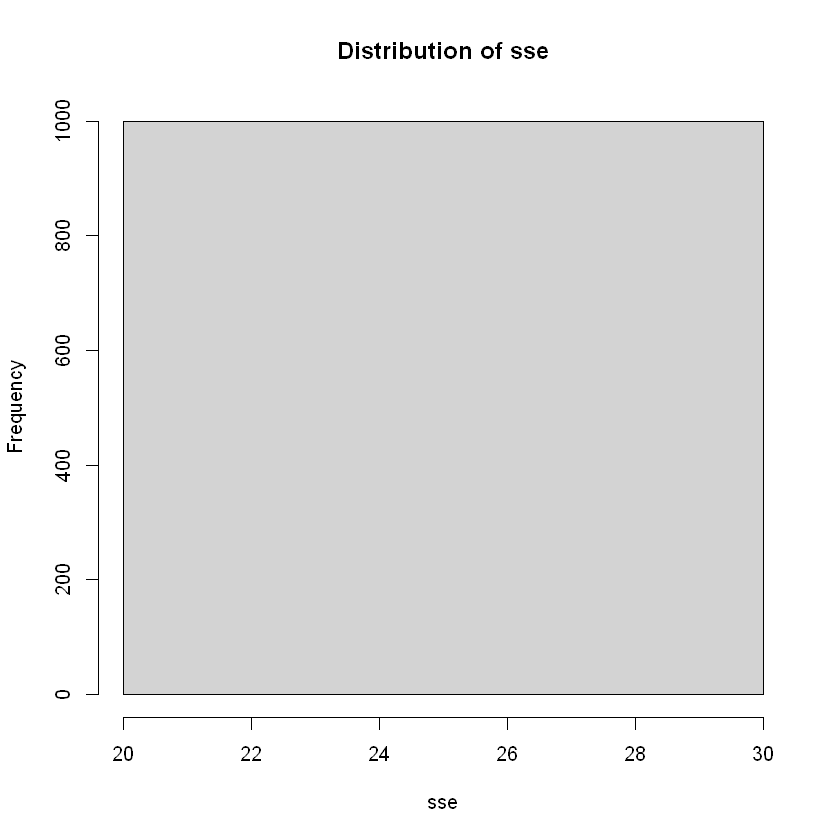

In [9]:
library(ClusterR)


k <- 3 # 聚类的个数
n <- 1000 # 求解尝试的次数

rec <- matrix(ncol = k + 1, nrow = n)

pb <- txtProgressBar(style = 3)
for (i in 1:n) {
  res <- Cluster_Medoids(x, k, seed = i)
  rec[i, ] <- c(sort(res$medoid_indices), res$best_td)
  setTxtProgressBar(pb, i / n)
}

opt <- which.min(rec[, k + 1])

cat("\n")
cat("Exchange Algorithm solutuion")
cat("\n")
cat("medoids:", rec[opt, 1:k])
cat("\n")
cat("sse:", rec[opt, k + 1])

hist(rec[, k + 1], main = "Distribution of sse", xlab = "sse")

### cluster包

In [ ]:
library(cluster)

k <- 3   #聚类的个数
pm <- pam(x, k, metric = "euclidean")

cat("package cluster solutuion")
cat("\n")
cat("medoid_indices:", sort(pm$id.med))
cat("\n")
cat("best_td:", n * pm$objective[2])

package cluster solutuion
medoid_indices: 11 45 57
best_dissimilarity: 27.72188

### fastkmedoids包

In [42]:
library(fastkmedoids)
pm <- pam(dv,100,3)

cat("pam(package fastkmedoids) solutuion:")
cat("\n")
cat("medoid_indices:", sort(pm@medoids)+1)
cat("\n")
cat("best_td:", pm@td)

pam(package fastkmedoids) solutuion:
medoid_indices: 11 45 57
best_cost: 27.72188

In [43]:
library(fastkmedoids)
fp <- fastpam(dv,100,3)

cat("fastpam(package fastkmedoids) solutuion:")
cat("\n")
cat("medoid_indices:", sort(fp@medoids)+1)
cat("\n")
cat("best_td:", fp@td)

fastpam(package fastkmedoids) solutuion:
medoid_indices: 11 45 57
best_cost: 27.72188

## k=4

可见此时ClusterR包、cluster包算法未能找到最优解

In [ ]:
library(ClusterR)

# 数据生成
n <- 100 # 数据量
set.seed(3)
x <- rbind(
  matrix(rnorm(n, sd = 0.25), ncol = 2),
  matrix(rnorm(n, mean = 1, sd = 0.25), ncol = 2)
)
# 距离方阵
dm <- distance_matrix(x, upper = TRUE, diagonal = TRUE)

### Exhaust法

In [23]:
k <- 4 # 聚类的个数
sl <- exhaust(dm, k)

cat("\n")
cat("Exhaust Algorithm solutuion")
cat("\n")
cat("medoid_indices:", sl$medoids)
cat("\n")
cat("best_td:", sl$td)

  |======================================================================| 100%
Exhaust Algorithm solutuion
medoid_indices: 11 45 61 67
best_td:

### Lloyd_Similar法

In [32]:
k <- 4 # 聚类个数
t <- 100 # 试验次数

rc <- matrix(nc = k + 1, nr = t) # 用于记录簇心及簇心距离总和
colnames(rc)=c(paste0("medoid",1:k),"td")
pb <- txtProgressBar(style = 3)
for (seed in 1:t) {
  rs <- LS(dm, k, seed)
  rc[seed, 1:k] <- sort(rs$medoids)
  rc[seed, k + 1] <- sort(rs$td)
  setTxtProgressBar(pb, seed / t)
}

cat("\n")
cat("best solutions:")
cat("\n")
print(rc[rc[, k + 1] == min(rc[, k + 1]), ])   #最优解

bc <- table(rc[, k + 1])[1]
cat("\n")
cat(paste0("hit probability: ", bc / t))     #最优解命中率

  |======================================================================| 100%
best solutions:
     medoid1 medoid2 medoid3 medoid4     cost
[1,]       2      26      28      57 25.71315
[2,]       2      26      28      57 25.71315
[3,]       2      26      28      57 25.71315
[4,]       2      26      28      57 25.71315
[5,]       2      26      28      57 25.71315
[6,]       2      26      28      57 25.71315
[7,]       2      26      28      57 25.71315
[8,]       2      26      28      57 25.71315

hit probability: 0.08

### Exchange法

  |======================================================================| 100%

best medoids: (11, 45, 61, 67)
best td: 23.1397041438685
hit probability: 0.28

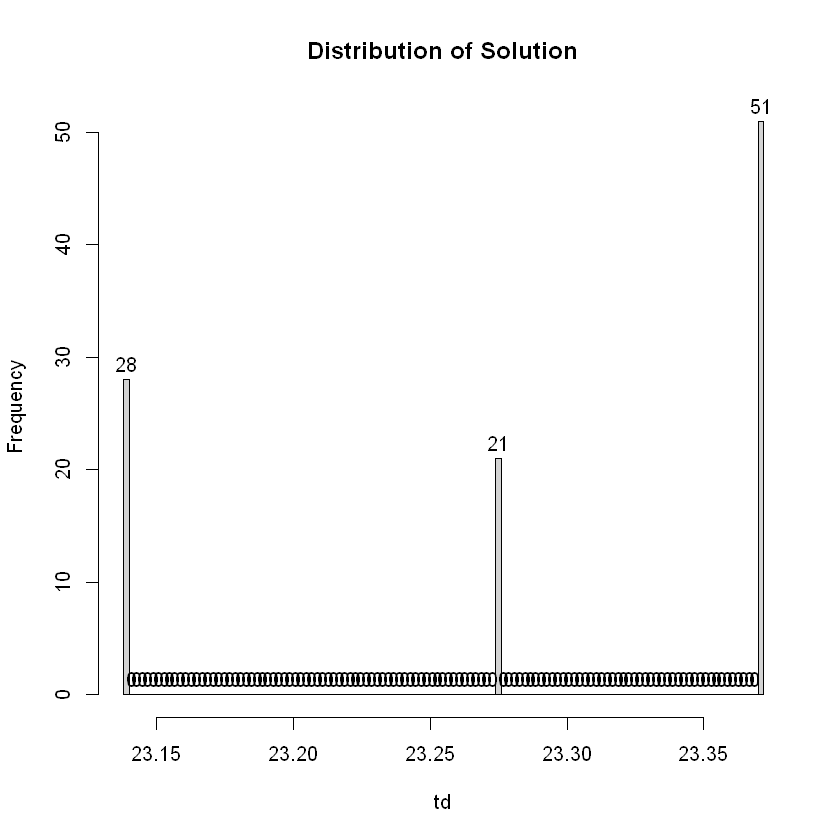

In [20]:
k <- 4 # 聚类个数
T <- 100 # 试验次数
td_r <- vector(length = T) # 用于记录每次试验的结果
rc <- matrix(nr = T, nc = k + 1)

pb <- txtProgressBar(style = 3)
for (seed in 1:T) {
  sl <- exchange(dm, k, seed) # sl-solution

  rc[seed, 1] <- sl$td
  rc[seed, 2:(k + 1)] <- sl$medoids
  setTxtProgressBar(pb, seed / T)
}

id <- which.min(rc[, 1])
cat("\n")
bc <- table(rc[, 1])[1]
cat("\n")
cat(paste0("best medoids: (", toString(rc[id, 2:(k + 1)]), ")"))
cat("\n")
cat(paste0("best td: ", names(bc)))
cat("\n")
cat(paste0("hit probability: ", bc / T))    #最优解命中率
hist(rc[, 1] ,100, labels = TRUE,xlab = "td", main = "Distribution of Solution")

### Build-Swap法

In [ ]:
m <- 4  #聚类的个数
sseR <- NULL

# build phase
s <- which.min(rowSums(dm))
while (length(s) < m) {
  ri <- matrix(nc = 2, nr = 0) # 用于记录点i的情况
  for (i in (1:n)[-s]) {
    gi <- 0
    for (j in (1:n)[-c(s, i)]) {
      gi <- gi + max(min(dm[j, s]) - dm[j, i], 0)
    }
    ri <- rbind(ri, matrix(c(i, gi), nc = 2, byrow = TRUE))
  }
  s <- c(s, ri[which.max(ri[, 2]), 1])
}
sse <- 0
# 计算簇心集s的sse
for (u in 1:m) {
  h <- s[-u]
  b <- TRUE # 到u类最近的点
  for (v in h) {
    b <- (b & (dm[, s[u]] < dm[, v]))
  }
  sse <- sse + sum(dm[b, s[u]])
}
sseR <- c(sseR, sse)

# swap phase
repeat{
  T <- matrix(0, nc = n, nr = n)
  for (i in s) {
    for (h in (1:n)[-s]) {
      for (j in (1:n)[-c(s, h)]) {
        if (dm[j, i] > min(dm[j, s])) {
          if (dm[j, h] < min(dm[j, s])) {
            k <- dm[j, h] - min(dm[j, s])
          } else {
            k <- 0
          }
        } else {
          if (dm[j, h] < min(dm[j, s[-i]])) {
            k <- dm[j, h] - min(dm[j, s])
          } else {
            k <- dm[j, h] - min(dm[j, s[-i]])
          }
        }
        T[i, h] <- T[i, h] + k
      }
    }
  }

  if (min(T) >= 0) {
    break
  } else {
    id <- which(T == min(T), arr.ind = TRUE)
    s[s == id[1]] <- id[2]
    sse <- 0
    # 计算簇心集s的sse
    for (u in 1:m) {
      h <- s[-u]
      b <- TRUE # 到u类最近的点
      for (v in h) {
        b <- (b & (dm[, s[u]] < dm[, v]))
      }
      sse <- sse + sum(dm[b, s[u]])
    }
    sseR <- c(sseR, sse)
  }
}

cat("pamBS Algorithm solutuion")
cat("\n")
cat("medoid_indices:", sort(s))
cat("\n")
cat("best_td:", sse)

pamBS Algorithm solutuion
medoid_indices: 11 45 61 67
best_dissimilarity: 23.1397

### ClusterR包

In [ ]:
library(ClusterR)

k <- 4   #聚类的个数
cm <- Cluster_Medoids(x, k, distance_metric = "euclidean")

cat("package ClusterR solutuion")
cat("\n")
cat("medoid_indices:", sort(cm$medoid_indices))
cat("\n")
cat("best_td:", cm$best_td)

package ClusterR solutuion
medoid_indices: 11 45 63 85
best_dissimilarity: 23.37088

### cluster包

In [ ]:
library(cluster)

k <- 4   #聚类的个数
pm <- pam(x, k, metric = "euclidean")

cat("package cluster solutuion")
cat("\n")
cat("medoid_indices:", sort(pm$id.med))
cat("\n")
cat("best_td:", n * pm$objective[2])

package cluster solutuion
medoid_indices: 11 45 63 85
best_dissimilarity: 23.37088

### fastkmedoids包

In [44]:
library(fastkmedoids)
pm <- pam(dv,100,4)

cat("pam(package fastkmedoids) solutuion:")
cat("\n")
cat("medoid_indices:", sort(pm@medoids)+1)
cat("\n")
cat("best_td:", pm@td)

pam(package fastkmedoids) solutuion:


medoid_indices: 11 45 63 85
best_cost: 23.37088

In [45]:
library(fastkmedoids)
fp <- fastpam(dv,100,4)

cat("fastpam(package fastkmedoids) solutuion:")
cat("\n")
cat("medoid_indices:", sort(fp@medoids)+1)
cat("\n")
cat("best_td:", fp@td)

fastpam(package fastkmedoids) solutuion:
medoid_indices: 11 45 63 85
best_cost: 23.37088

## k=5

可见此时Exchange法、Build-Swap法、ClusterR包算法未能找到最优解

In [ ]:
library(ClusterR)

# 数据生成
n <- 100 # 数据量
set.seed(3)
x <- rbind(
  matrix(rnorm(n, sd = 0.25), ncol = 2),
  matrix(rnorm(n, mean = 1, sd = 0.25), ncol = 2)
)
# 距离方阵
dm <- distance_matrix(x, upper = TRUE, diagonal = TRUE)

### Exhaust法

In [ ]:
k <- 5   #聚类的个数

ss <- combn(n, k) # 可能的medoids组合
m <- ncol(ss) # 可能的medoids组合个数

sseRC <- rep(Inf, m)
pb <- txtProgressBar(style = 3)
for (i in (1:m)) {
  s <- ss[, i]
  # 计算簇心集s的sse
  sse <- 0
  for (u in 1:k) {
    h <- s[-u]
    b <- TRUE # 到u类最近的点
    for (v in h) {
      b <- (b & (dm[, s[u]] < dm[, v]))
    }
    sse <- sse + sum(dm[b, s[u]])
  }
  sseRC[i] <- sse
  setTxtProgressBar(pb, i / m)
}

id <- which.min(sseRC)
cat("\n")
cat("Exhaust Algorithm solutuion")
cat("\n")
cat("medoid_indices:", ss[, id])
cat("\n")
cat("best_td:", sseRC[id])

#计算非常慢，难以忍受
#Exhaust Algorithm solutuion
#medoid_indices: 11 45 70 75 90
#best_td: 20.61164

### Lloyd_Similar法

In [33]:
k <- 5 # 聚类个数
t <- 100 # 试验次数

rc <- matrix(nc = k + 1, nr = t) # 用于记录簇心及簇心距离总和
colnames(rc)=c(paste0("medoid",1:k),"td")
pb <- txtProgressBar(style = 3)
for (seed in 1:t) {
  rs <- LS(dm, k, seed)
  rc[seed, 1:k] <- sort(rs$medoids)
  rc[seed, k + 1] <- sort(rs$td)
  setTxtProgressBar(pb, seed / t)
}

cat("\n")
cat("best solutions:")
cat("\n")
print(rc[rc[, k + 1] == min(rc[, k + 1]), ])   #最优解

bc <- table(rc[, k + 1])[1]
cat("\n")
cat(paste0("hit probability: ", bc / t))     #最优解命中率

  |======================================================================| 100%
best solutions:
 medoid1  medoid2  medoid3  medoid4  medoid5     cost 
11.00000 28.00000 38.00000 82.00000 94.00000 21.35014 

hit probability: 0.01

### Exchange法

  |======================================================================| 100%

best medoids: (11, 45, 70, 75, 90)
best td: 20.6116425414116
hit probability: 0.62

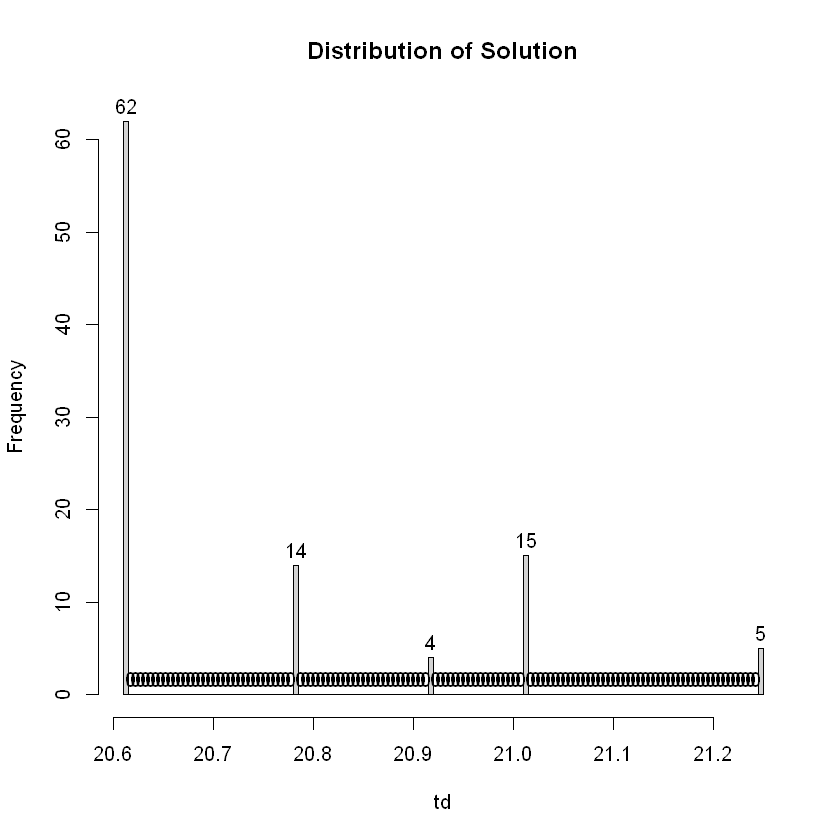

In [21]:
k <- 5 # 聚类个数
T <- 100 # 试验次数
td_r <- vector(length = T) # 用于记录每次试验的结果
rc <- matrix(nr = T, nc = k + 1)

pb <- txtProgressBar(style = 3)
for (seed in 1:T) {
  sl <- exchange(dm, k, seed) # sl-solution

  rc[seed, 1] <- sl$td
  rc[seed, 2:(k + 1)] <- sl$medoids
  setTxtProgressBar(pb, seed / T)
}

id <- which.min(rc[, 1])
cat("\n")
bc <- table(rc[, 1])[1]
cat("\n")
cat(paste0("best medoids: (", toString(rc[id, 2:(k + 1)]), ")"))
cat("\n")
cat(paste0("best td: ", names(bc)))
cat("\n")
cat(paste0("hit probability: ", bc / T))     #最优解命中率
hist(rc[, 1] ,100, labels = TRUE,xlab = "td", main = "Distribution of Solution")

### Build-Swap法

In [ ]:
m <- 5  #聚类的个数
sseR <- NULL

# build phase
s <- which.min(rowSums(dm))
while (length(s) < m) {
  ri <- matrix(nc = 2, nr = 0) # 用于记录点i的情况
  for (i in (1:n)[-s]) {
    gi <- 0
    for (j in (1:n)[-c(s, i)]) {
      gi <- gi + max(min(dm[j, s]) - dm[j, i], 0)
    }
    ri <- rbind(ri, matrix(c(i, gi), nc = 2, byrow = TRUE))
  }
  s <- c(s, ri[which.max(ri[, 2]), 1])
}
sse <- 0
# 计算簇心集s的sse
for (u in 1:m) {
  h <- s[-u]
  b <- TRUE # 到u类最近的点
  for (v in h) {
    b <- (b & (dm[, s[u]] < dm[, v]))
  }
  sse <- sse + sum(dm[b, s[u]])
}
sseR <- c(sseR, sse)

# swap phase
repeat{
  T <- matrix(0, nc = n, nr = n)
  for (i in s) {
    for (h in (1:n)[-s]) {
      for (j in (1:n)[-c(s, h)]) {
        if (dm[j, i] > min(dm[j, s])) {
          if (dm[j, h] < min(dm[j, s])) {
            k <- dm[j, h] - min(dm[j, s])
          } else {
            k <- 0
          }
        } else {
          if (dm[j, h] < min(dm[j, s[-i]])) {
            k <- dm[j, h] - min(dm[j, s])
          } else {
            k <- dm[j, h] - min(dm[j, s[-i]])
          }
        }
        T[i, h] <- T[i, h] + k
      }
    }
  }

  if (min(T) >= 0) {
    break
  } else {
    id <- which(T == min(T), arr.ind = TRUE)
    s[s == id[1]] <- id[2]
    sse <- 0
    # 计算簇心集s的sse
    for (u in 1:m) {
      h <- s[-u]
      b <- TRUE # 到u类最近的点
      for (v in h) {
        b <- (b & (dm[, s[u]] < dm[, v]))
      }
      sse <- sse + sum(dm[b, s[u]])
    }
    sseR <- c(sseR, sse)
  }
}

cat("pamBS Algorithm solutuion")
cat("\n")
cat("medoid_indices:", sort(s))
cat("\n")
cat("best_td:", sse)

pamBS Algorithm solutuion
medoid_indices: 11 45 62 72 79
best_dissimilarity: 21.0301

### ClusterR包

In [8]:
library(ClusterR)

k <- 5   #聚类的个数
cm <- Cluster_Medoids(x, k, seed = "euclidean")

cat("package ClusterR solutuion")
cat("\n")
cat("medoid_indices:", sort(cm$medoid_indices))
cat("\n")
cat("best_td:", cm$best_td)

Warning message:
"The `seed` argument of `Cluster_Medoids()` is deprecated as of ClusterR 1.2.6.
ℹ The 'seed' parameter will be removed in version 1.4.0"


ERROR: Error in eval(expr, envir, enclos): Not compatible with requested type: [type=character; target=integer].


### cluster包

In [ ]:
library(cluster)

k <- 5   #聚类的个数
pm <- pam(x, k, metric = "euclidean")

cat("package cluster solutuion")
cat("\n")
cat("medoid_indices:", sort(pm$id.med))
cat("\n")
cat("best_td:", n * pm$objective[2])

package cluster solutuion
medoid_indices: 11 45 70 75 90
best_dissimilarity: 20.61164

### fastkmedoids包

In [47]:
library(fastkmedoids)
pm <- pam(dv,100,5)

cat("pam(package fastkmedoids) solutuion:")
cat("\n")
cat("medoid_indices:", sort(pm@medoids)+1)
cat("\n")
cat("best_td:", pm@td)

pam(package fastkmedoids) solutuion:
medoid_indices: 11 45 70 75 90
best_cost: 20.61164

In [46]:
library(fastkmedoids)
fp <- fastpam(dv,100,5)

cat("fastpam(package fastkmedoids) solutuion:")
cat("\n")
cat("medoid_indices:", sort(fp@medoids)+1)
cat("\n")
cat("best_td:", fp@td)

fastpam(package fastkmedoids) solutuion:


medoid_indices: 11 45 70 75 90
best_cost: 20.61164

## 结果汇总

数字中加粗的为最优解

- 可见Exchange、Lloyd_Similar和B-S算法均是局部最优算法，不能保证获得最优解
- 但穷举法耗时过长，时间复杂度为$O(n!)$

|                               | K=2      | K=3        | K=4          | K=5                |
| ----------------------------- | -------- | ---------- | ------------ | ------------------ |
| **Exhaust**                  |          |            |              |                    |
| medoids                | **20 57**    | **20 61 67**   | **11 45 61 67** | **11 45 70 75 90** |
| td            | **31.8649** | **27.2827**   | **23.1397**      | **20.6116** |
| **Lloyd_Similar** | 100Test(1.0) | 100Test(0.09) | 100Test(0.08) | 100Test(0.01) |
| medoids | **20 57** | 6      26      57 | 2      26      28      57 | 11  28  38 82  94 |
| td | **31.8649** | 28.15211 | 25.71315 | 21.35014 |
| **Exchange**                  | 100Test(1.0)| 100Test(0.16)|100Test(0.28)|100Test(0.62)|
| medoids                | **20 57**    | **20 61 67**|**11 45 61 67**| **11 45 70 75 90**|
| td            | **31.8649** | **27.2827**   | **23.1397**      |**20.6116**|
| **B-S(自我实现)**                     |          |            |              |                    |
| medoids                | **20 57**    | **20 61 67**   | 11 45 61 67  | 11 45 62 72 79     |
| td            | **31.8649** | **27.2827**   | **23.1397**      | 21.0301            |
| **B-S(ClusterR)** |          |            |              |                    |
| medoids                | **25 57** | 11 45 57   | 11 45 63 85  | 11 45 56 61 63     |
| td            | **31.97467** | 27.7218   | 23.3708     | 21.2476           |
| **B-S(cluster)** |          |            |              |                    |
| medoids                | **20 57**    | 11 45 57   | 11 45 63 85  | **11 45 70 75 90**     |
| td            | **31.8649** | 27.7218   | 23.3708     | **20.6116**           |
| **B-S(fastkmedoids)** |  |  |  |  |
| medoids | **20 57** | 11 45 57 | 11 45 63 85 | **11 45 70 75 90** |
| td | **31.8649** | 27.7218 | 23.3708 | **20.6116** |
| **fast B-S(fastkmedoids)** |  |  |  |  |
| medoids | **20 57** | 11 45 57 | 11 45 63 85 | **11 45 70 75 90** |
| td | **31.8649** | 27.7218 | 23.3708 | **20.6116** |
| **B-S(matlab自带)** |          |            |              |                    |
| medoids                | **20  57**   | **20 61 67**   | 11 45 63 85  | **11 45 70 75 90**     |
| td            | **31.8649**  | **27.2827**   | 23.3709      | **20.6116**            |
| **B-S(sklearn)** |          |            |              |                    |
| medoids                | **20  57** | 11, 45, 57 | 6, 8, 11, 57 | 11, 34, 45, 61, 67 |
| td            | **31.8649**  | 27.7218   | 25.4060     | 21.2282           |